### Alpha-Line Interpolation Between Robust/Feeble Model

##### Summary
Load model trained with federated adversarial training (FAT, high robustness against adversarial attacks) and FedAvg (low robustness). We make linear combinations of parameters of models and see if the robustness gradually changes as we sweep between FAT and FedAvg models.

Figure 4c

In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

torch.cuda.empty_cache()


In [3]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = "cifar10") # Indicate dataset here

# Load models for FAT and FedAvg
save_path_FAT = 'path_to_trained_FAT_weights'
save_path_FedAvg = 'path_to_trained_Fedavg_weights'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 102.21it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


In [4]:
# Linear extrapolation of model for each layer
stepsize_alpha = 0.05
alpha_set = np.arange(0,1+stepsize_alpha,stepsize_alpha)

models_test = []

params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()


for (a) in alpha_set:
    # first make the model with empty weights
    new_model = copy.deepcopy(model_FAT)
    new_model.eval()
    new_weight_dict = copy.deepcopy(params_FAT)
    for key in params_FAT:
        new_weight_dict[key] = a*params_FedAvg[key] + (1-a)*params_FAT[key] 
    new_model.load_state_dict(new_weight_dict)
    models_test += [new_model]


In [5]:
# Perform transfer attack from one client to another and record stats
# models_test = [model_Fedavg, model_FAT]

alpha_list = alpha_set.tolist()
num_trials = 5
acc_store_agg = np.zeros([num_trials, len(alpha_list)])
adv_store_agg = np.zeros([num_trials, len(alpha_list)])

for itt in range(num_trials):

    # Run Measurements for both targetted and untargeted analysis
    victim_idxs = range(len(models_test))
    logs_adv = generate_logs_adv(len(models_test))
    custom_batch_size = 100
    eps = 3

    dataloader = load_client_data(clients = clients, c_id = 0, mode = 'all') # or test/train
    cross_attack(logs_adv, victim_idxs, dataloader, models_test, custom_batch_size, eps)

    metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
                'adv_similarities_untarget','adv_target','adv_miss']

    adv_miss = get_metric_list("adv_miss", logs_adv, victim_idxs)
    acc = get_metric_list("orig_acc_transfers", logs_adv, victim_idxs)

    # Print along diagonal and plot "robustness against white-box attacks (self)"
    adv_list = []
    acc_list = []
    for i in range(adv_miss.shape[0]):
        adv_list += [adv_miss[i,i]]
        acc_list += [acc[i,i]]

    acc_store_agg[itt,:] = np.array(acc_list)
    adv_store_agg[itt,:] = np.array(adv_list)



	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Ad

In [6]:
acc_list_true = np.mean(acc_store_agg, axis = 0)
adv_list_true = np.mean(adv_store_agg, axis = 0)

acc_list_std = np.std(acc_store_agg, axis = 0)
adv_list_std = np.std(adv_store_agg, axis = 0)

print(acc_list_true)
print(acc_list_std)
print(adv_list_true)
print(adv_list_std)

[0.82 0.81 0.81 0.80 0.81 0.83 0.79 0.82 0.81 0.78 0.81 0.81 0.83 0.82
 0.83 0.83 0.83 0.84 0.87 0.85 0.82]
[0.03 0.02 0.03 0.07 0.05 0.03 0.05 0.05 0.04 0.05 0.04 0.03 0.02 0.02
 0.03 0.03 0.02 0.02 0.01 0.02 0.03]
[0.51 0.49 0.48 0.49 0.42 0.42 0.39 0.35 0.34 0.31 0.24 0.18 0.18 0.13
 0.11 0.09 0.06 0.05 0.04 0.02 0.01]
[0.04 0.04 0.03 0.02 0.03 0.05 0.04 0.03 0.05 0.06 0.03 0.04 0.04 0.05
 0.02 0.03 0.02 0.01 0.01 0.02 0.01]


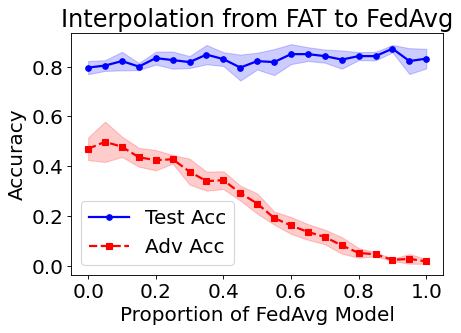

In [9]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# Sample data
x = alpha_list
y1 = acc_list_true
y2 = adv_list_true

# Compute standard deviation
std1 = acc_list_std  # Replace with actual standard deviation values
std2 = adv_list_std  # Replace with actual standard deviation values

font = {'family': 'normal',
        'weight': 'normal',
        'size': 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6, 4))

# Plot the first line (y1) with shaded region for standard deviation
plt.plot(x, y1, label='Test Acc', color='b', linewidth=2, linestyle='-', marker='o', markersize=5)
plt.fill_between(x, y1 - std1, y1 + std1, color='b', alpha=0.2)

# Plot the second line (y2) with shaded region for standard deviation
plt.plot(x, y2, label='Adv Acc', color='r', linewidth=2, linestyle='--', marker='s', markersize=5)
plt.fill_between(x, y2 - std2, y2 + std2, color='r', alpha=0.2)

# Set plot title and labels
plt.title('Interpolation from FAT to FedAvg')
plt.xlabel('Proportion of FedAvg Model')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Show the plot
plt.show()
